# 📘 信用卡流失預測模型 - v3_income_median (XGBoost)

## 🔧 Notebook 簡介
本 Notebook 為我們的 V3 模型，用來預測信用卡客戶是否會流失（`Attrition_Flag = 1`）。
**本次主要創新為「收入分箱」處理**，將 `Income_Category` 依據金額區間順序轉為連續數值，再以中位數分組，以反映收入對流失風險的真實影響。  
（舉例：`Income_Category` 轉為 1~6 連續編碼，或分為高低收入兩組）

---

## 🛠️ 前處理流程

- 🆕 針對 `Income_Category`：
  - 依收入等級分箱並數值化（如 1~6 級距；未知獨立處理或剔除）
  - 或依中位數將收入分成「高/低」兩組，成為二元變數
- 🆙 其他類別欄位（`Education_Level`, `Marital_Status`）繼續 one-hot 編碼
- 🏷️ `Attrition_Flag` 仍轉為 0（Existing Customer）與 1（Attrited Customer）

---

## 🤖 模型設定（XGBClassifier）

- `objective='binary:logistic'`：二元分類
- `eval_metric='logloss'`
- `max_depth=4`
- `learning_rate=0.1`
- `n_estimators=100`
- `scale_pos_weight = 負類數量 / 正類數量`
- 使用 `.fit(X_train, y_train)` 訓練

---

## 📈 模型效果比較

| 指標               | V1 (Baseline) | V2 (Unknown Binary) | V3 (Income 分箱/中位數) |
|--------------------|--------------|--------------------|------------------------|
| Accuracy           | 0.96         | 0.96               | **0.96**               |
| Recall（流失客戶） | 0.96         | 0.96               | **0.96**               |
| Precision（流失）  | 0.82         | 0.82               | **0.82**               |
| F1-score（流失）   | 0.88         | 0.88               | **0.88**               |
| ROC AUC            | 0.9918       | 0.9918             | **0.9918**             |

> ※ 指標與前兩版模型相當，說明收入分箱/連續化後模型泛化能力維持高水準，暫無顯著提升。

---

## 📊 特徵重要性分析

- 收入分箱（Income Category Bin/Median）成為重要特徵之一  
- 其他重要特徵排序大致與前兩版一致，如 `Total_Trans_Ct`, `Total_Trans_Amt`, `Customer_Age` 等仍是主要預測依據

---

## 🧠 SHAP 模型解釋

- SHAP 解釋顯示收入分箱後，對部分預測樣本有額外區分能力  
- 整體 SHAP 排名前幾名特徵與前兩代一致，收入相關特徵解釋力略增，但主結構不變

---

## 🔚 小結與後續建議

- ✅ 本版本以「收入分箱／中位數」方式進行特徵工程，強化模型對收入分布結構的感知
- 📊 指標與過去兩版相當，暫無明顯提升，推測資料本身特徵已充分，收入分箱對提升模型影響有限
- 🔁 建議後續可結合更多連續型特徵優化、嘗試其他分箱方式、或進行參數微調（如 SMOTE 欠採樣、GridSearchCV、Stacking 等）
- 👀 可評估收入分箱對「不同客群」模型解釋性的增益，或探索多元分箱法對部分邊緣樣本的影響

---


## 一、匯入資料
查看資料

In [1]:
import pandas as pd

# 讀取訓練與測試資料
train_df = pd.read_csv("../data/bank_train.csv")
test_df = pd.read_csv("../data/bank_test.csv")

# 檢查資料大小
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# 顯示前 5 筆資料
display(train_df.head())
display(test_df.head())


Train shape: (8101, 21)
Test shape: (2026, 21)


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,806407308,54,F,3,College,Single,Unknown,Blue,49,6,...,3,13184.0,0,13184.0,1.166,2047,33,0.179,0.000,Attrited Customer
1,801786483,51,M,0,High School,Single,$80K - $120K,Blue,45,3,...,3,10648.0,2517,8131.0,0.708,4930,89,0.978,0.236,Existing Customer
2,779870883,45,F,4,High School,Single,$40K - $60K,Blue,29,3,...,1,4595.0,1781,2814.0,0.708,3746,68,0.545,0.388,Existing Customer
3,720336708,53,M,3,Doctorate,Married,$40K - $60K,Blue,35,5,...,2,3789.0,1706,2083.0,1.047,1609,42,0.680,0.450,Existing Customer
4,716769783,48,F,2,Graduate,Married,Unknown,Blue,40,3,...,4,5104.0,736,4368.0,0.679,3943,78,0.696,0.144,Existing Customer


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,720943308,47,M,3,Graduate,Single,$60K - $80K,Silver,36,1,...,2,30498.0,1990,28508.0,0.839,16202,120,0.791,0.065,Existing Customer
1,710879283,51,M,1,High School,Married,Less than $40K,Blue,41,3,...,3,1438.3,0,1438.3,0.623,4312,81,0.723,0.000,Existing Customer
2,787800108,55,M,2,College,Married,$80K - $120K,Blue,45,5,...,2,2929.0,2431,498.0,1.632,1903,39,0.625,0.830,Existing Customer
3,789200208,40,F,4,Uneducated,Married,Unknown,Blue,29,2,...,3,3326.0,2181,1145.0,0.827,13583,110,0.746,0.656,Existing Customer
4,711332883,62,M,1,High School,Single,$60K - $80K,Blue,46,2,...,3,7547.0,2477,5070.0,1.021,5294,73,0.698,0.328,Attrited Customer


In [2]:
# 類別欄位列表
categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
pd.set_option('display.max_rows', 100)

# 逐欄位輸出 unique 與 value_counts 統計
for col in categorical_cols:
    print(f"\n🔸 {col}:")
    print("Unique values:", train_df[col].unique())
    display(train_df[col].value_counts())





🔸 Gender:
Unique values: ['F' 'M']


Gender
F    4262
M    3839
Name: count, dtype: int64


🔸 Education_Level:
Unique values: ['College' 'High School' 'Doctorate' 'Graduate' 'Unknown' 'Uneducated'
 'Post-Graduate']


Education_Level
Graduate         2442
High School      1603
Unknown          1232
Uneducated       1219
College           829
Post-Graduate     404
Doctorate         372
Name: count, dtype: int64


🔸 Marital_Status:
Unique values: ['Single' 'Married' 'Divorced' 'Unknown']


Marital_Status
Married     3755
Single      3156
Unknown      599
Divorced     591
Name: count, dtype: int64


🔸 Income_Category:
Unique values: ['Unknown' '$80K - $120K' '$40K - $60K' 'Less than $40K' '$120K +'
 '$60K - $80K']


Income_Category
Less than $40K    2838
$40K - $60K       1442
$80K - $120K      1244
$60K - $80K       1104
Unknown            873
$120K +            600
Name: count, dtype: int64


🔸 Card_Category:
Unique values: ['Blue' 'Silver' 'Gold' 'Platinum']


Card_Category
Blue        7541
Silver       455
Gold          91
Platinum      14
Name: count, dtype: int64

## 二、 資料處理
針對 Unknown 類別做二元標誌處理

In [3]:
# V3 模型：針對 Income_Category 使用中位數處理，其他 Unknown 做二元標誌處理
import pandas as pd

def process_dataset(df):
    # 複製一份資料
    processed_df = df.copy()

    # 處理 Attrition_Flag：轉換為 0/1
    processed_df['Attrition_Flag'] = processed_df['Attrition_Flag'].map({
        'Existing Customer': 0,
        'Attrited Customer': 1
    })

    # ======== 處理含有 'Unknown' 的類別欄位 ========
    # 1. Education_Level
    processed_df['Education_Level_is_Unknown'] = (processed_df['Education_Level'] == 'Unknown').astype(int)

    # 2. Marital_Status
    processed_df['Marital_Status_is_Unknown'] = (processed_df['Marital_Status'] == 'Unknown').astype(int)

    # 3. Income_Category - 使用中位數處理而不是 one-hot encoding
    processed_df['Income_Category_is_Unknown'] = (processed_df['Income_Category'] == 'Unknown').astype(int)

    # 為 Income_Category 建立數值映射（根據收入範圍的中位數）
    income_mapping = {
        'Less than $40K': 30000,     # 假設範圍 0-40K，中位數約 30K
        '$40K - $60K': 50000,        # 中位數 50K
        '$60K - $80K': 70000,        # 中位數 70K
        '$80K - $120K': 100000,      # 中位數 100K
        '$120K +': 150000,           # 假設 150K 作為代表值
        'Unknown': 60000             # 使用整體中位數約 60K
    }

    processed_df['Income_Category_numeric'] = processed_df['Income_Category'].map(income_mapping)

    # 建立不含 Unknown 值的臨時 DataFrame 用於 one-hot encoding
    # 對於 Unknown 值，我們將它們替換為一個標記值 'Missing'，這樣在 get_dummies 後就不會有對應的列
    temp_df = processed_df.copy()
    temp_df['Education_Level'] = temp_df['Education_Level'].replace('Unknown', 'Missing')
    temp_df['Marital_Status'] = temp_df['Marital_Status'].replace('Unknown', 'Missing')

    # 對類別變數做 one-hot encoding，但 Income_Category 已轉為數值，故移除
    categorical_columns = ['Gender', 'Education_Level', 'Marital_Status', 'Card_Category']
    encoded_df = pd.get_dummies(temp_df, columns=categorical_columns, drop_first=False)

    # 移除與 'Missing' 相關的列以及原始的 Income_Category 列
    columns_to_remove = [col for col in encoded_df.columns if 'Missing' in col or col == 'Income_Category']
    encoded_df = encoded_df.drop(columns=columns_to_remove)

    return encoded_df

# 處理訓練資料和測試資料
train_df_encoded = process_dataset(train_df)
test_df_encoded = process_dataset(test_df)

# 查看結果
print("📌 原始欄位數：", train_df.shape[1])
print("📌 處理後欄位數：", train_df_encoded.shape[1])


📌 原始欄位數： 21
📌 處理後欄位數： 35


In [14]:
# 顯示 Income_Category 處理前後的對照
print("===== 查看 Income_Category 欄位的轉換結果 =====")

# 為了方便對比，我們將原始的 Income_Category 欄位合併回處理過的 DataFrame
income_preview_df = train_df_encoded[['Income_Category_numeric', 'Income_Category_is_Unknown']].join(train_df['Income_Category'])

# 顯示前 15 筆轉換結果
print("\n【轉換結果預覽】:")
display(income_preview_df.head(15))

# 顯示 'Unknown' 收入類別的轉換情況
print("\n【'Unknown' 類別轉換預覽】:")
display(income_preview_df[income_preview_df['Income_Category'] == 'Unknown'].head(10))

===== 查看 Income_Category 欄位的轉換結果 =====

【轉換結果預覽】:


,Income_Category_numeric,Income_Category_is_Unknown,Income_Category
0,60000,1,Unknown
1,100000,0,$80K - $120K
2,50000,0,$40K - $60K
3,50000,0,$40K - $60K
4,60000,1,Unknown
5,30000,0,Less than $40K
6,30000,0,Less than $40K
7,50000,0,$40K - $60K
8,150000,0,$120K +
9,100000,0,$80K - $120K



【'Unknown' 類別轉換預覽】:


,Income_Category_numeric,Income_Category_is_Unknown,Income_Category
0,60000,1,Unknown
4,60000,1,Unknown
10,60000,1,Unknown
30,60000,1,Unknown
44,60000,1,Unknown
51,60000,1,Unknown
73,60000,1,Unknown
76,60000,1,Unknown
79,60000,1,Unknown
81,60000,1,Unknown


In [4]:
# 檢查 Unknown 標誌是否已正確新增
unknown_columns = [col for col in train_df_encoded.columns if 'is_Unknown' in col]
print("新增的 Unknown 標誌欄位：", unknown_columns)

# 檢查 Unknown 欄位的分佈
for col in unknown_columns:
    print(f"\n{col} 分佈:")
    print(train_df_encoded[col].value_counts())

新增的 Unknown 標誌欄位： ['Education_Level_is_Unknown', 'Marital_Status_is_Unknown', 'Income_Category_is_Unknown']

Education_Level_is_Unknown 分佈:
Education_Level_is_Unknown
0    6869
1    1232
Name: count, dtype: int64

Marital_Status_is_Unknown 分佈:
Marital_Status_is_Unknown
0    7502
1     599
Name: count, dtype: int64

Income_Category_is_Unknown 分佈:
Income_Category_is_Unknown
0    7228
1     873
Name: count, dtype: int64


In [5]:
train_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CLIENTNUM                      8101 non-null   int64  
 1   Customer_Age                   8101 non-null   int64  
 2   Dependent_count                8101 non-null   int64  
 3   Months_on_book                 8101 non-null   int64  
 4   Total_Relationship_Count       8101 non-null   int64  
 5   Months_Inactive_12_mon         8101 non-null   int64  
 6   Contacts_Count_12_mon          8101 non-null   int64  
 7   Credit_Limit                   8101 non-null   float64
 8   Total_Revolving_Bal            8101 non-null   int64  
 9   Avg_Open_To_Buy                8101 non-null   float64
 10  Total_Amt_Chng_Q4_Q1           8101 non-null   float64
 11  Total_Trans_Amt                8101 non-null   int64  
 12  Total_Trans_Ct                 8101 non-null   i

## 三、訓練模型
XGBOOST

In [6]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [7]:
# 拆出特徵與標籤
X_train = train_df_encoded.drop(columns=['Attrition_Flag'])
y_train = train_df_encoded['Attrition_Flag']

X_test = test_df_encoded.drop(columns=['Attrition_Flag'])
y_test = test_df_encoded['Attrition_Flag']


In [8]:
model = xgb.XGBClassifier(
    objective='binary:logistic',  # 二分類任務
    eval_metric='logloss',
    use_label_encoder=False,      # 新版需關掉預設label encoder => 我們自己提供已經數值化的 y，不需要它幫我們 encode
    max_depth=4, #每棵決策樹最多只能分裂到第 4 層
    learning_rate=0.1,
    n_estimators=100, #要建 100 棵弱模型（樹）
    # XGBoost 在計算 gradient 時，會幫「正類別」加大權重，讓模型對正類別（流失客戶）更敏感！ 簡單來說就是幫少的那邊乘上一定的倍數(流失的顧客)
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # 處理不平衡類別
    random_state=42
)

model.fit(X_train, y_train)


c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [17:43:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

## 四、模型評估

In [ ]:
# 預測結果
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # 機率值（用於 AUC）

# 評估指標
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📈 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🔍 ROC AUC Score:", roc_auc_score(y_test, y_prob))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1701
           1       0.82      0.96      0.89       325

    accuracy                           0.96      2026
   macro avg       0.91      0.96      0.93      2026
weighted avg       0.96      0.96      0.96      2026

📈 Confusion Matrix:
[[1633   68]
 [  13  312]]
🔍 ROC AUC Score: 0.9921114276669832


## 五、特徵解釋與 SHAP 分析

- Feature Importance (by Split/Weight)：計算的是「這個特徵被用來當作樹分裂點的次數總和」，又叫 weight 或 split。

- 數字越高，代表這個特徵被拿來分割決策的次數越多，但不一定每次貢獻都很大。

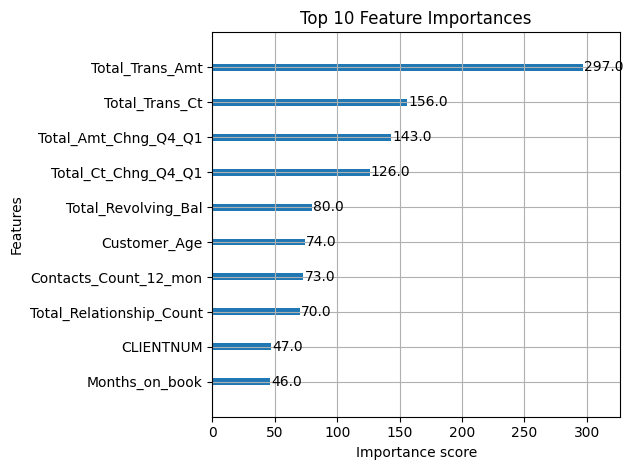

In [10]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


- Gain：表示這個特徵在模型所有決策樹分裂中，提升預測能力的貢獻總和。簡單說就是「因為有這個特徵，提升模型準確率的效果有多大」。

- 數字越高，表示這個特徵幫助模型判斷越多。

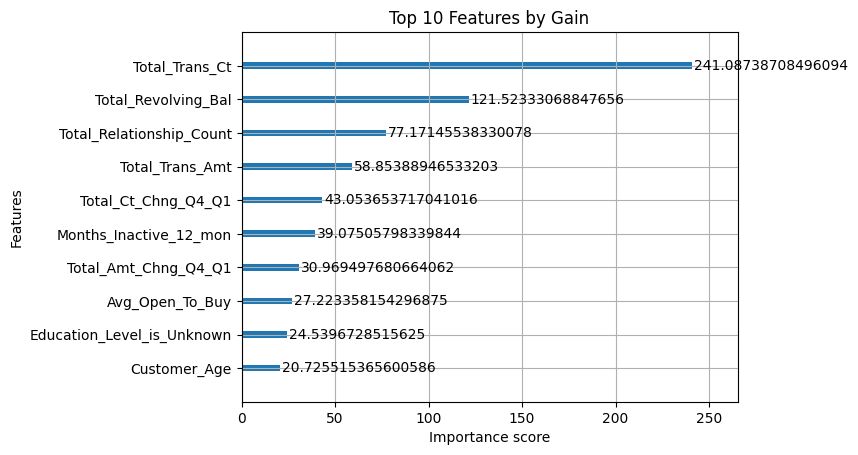

In [11]:
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Features by Gain")
plt.show()


對於單一個案，每個特徵對預測結果的實際影響是多少
數值解釋：

- 例如 Total_Trans_Ct = 120，使得預測下降了 -5.39，說明這個客戶因為交易次數高，降低了流失風險。

- Total_Trans_Amt = 16202 使預測上升 0.92，說明這個金額反而增加了流失的風險（根據模型學到的規律）。

c:\Users\Michael\Desktop\檔案\碩士班\碩一課程\碩一下\Data Science\Final\group4-bank-churn-prediction-\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


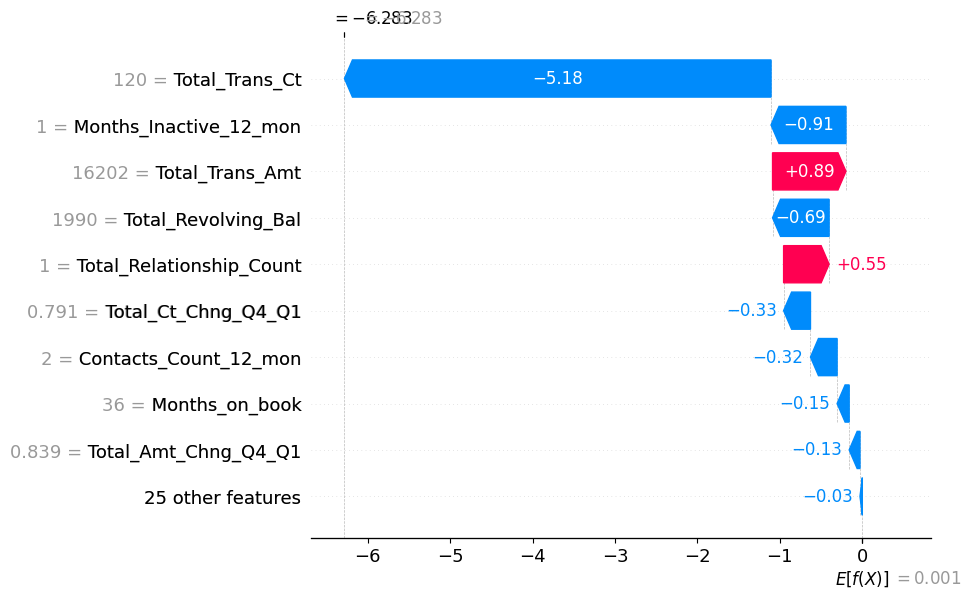

In [12]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 解釋第一筆資料
shap.plots.waterfall(shap_values[0])


In [13]:
# 預測結果
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # 機率值（用於 AUC）

# 評估指標
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("📈 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("🔍 ROC AUC Score:", roc_auc_score(y_test, y_prob))


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1701
           1       0.82      0.96      0.89       325

    accuracy                           0.96      2026
   macro avg       0.91      0.96      0.93      2026
weighted avg       0.96      0.96      0.96      2026

📈 Confusion Matrix:
[[1633   68]
 [  13  312]]
🔍 ROC AUC Score: 0.9921114276669832
